무비렌즈 데이터를 가지고 사용자 협업 필터링을 구현해 보자

In [ ]:
#surprise 모듈 설치 (추천시스템 패키지) 
#읽어오는 READER 클래스와 평점을 예측하는 predict, 모형을 평가하는 accuracy 모듈의 rmse와 mse 방법등을 제공한다


!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from surprise import Dataset
from surprise import Reader

from collections import defaultdict
import numpy as np
import pandas as pd


In [ ]:
movies = pd.read_csv("http://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/movies.csv")
ratings = pd.read_csv("http://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv")

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

#timestamp 정보를 사용하면 시간에 따른 사용자의 취향변화 등을 알 수 있음

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
movie_ratings = pd.merge(movies, ratings, left_on='movieId', right_on='movieId') #왼쪽 오른쪽 설정해서 merge

In [ ]:
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091


In [ ]:
movies.shape

(9125, 3)

In [ ]:
ratings.shape

(100004, 4)

In [ ]:
movie_ratings.shape

(100004, 6)

EDA 즉 데이터 분석을 데이터 모델링 전에 먼저 해줘야한다
* 영화별 평점수 min, max, med...
* 가장 평점이 많은 영화 10개는?
* 영화별 평점 평균 min, max, med...
* 가장 평점이 높은 영화 10개는(100개 이상 평점이 있는 영화중)

In [ ]:
# unique한게 9066 개정도 나오는데  60개 정도 rating이 없어서 이렇게 나온거임
movie_ratings["movieId"].nunique()

9066

In [ ]:
movie_rating_summary = movie_ratings[["movieId", "rating"]].groupby(["movieId"]).agg(["count","median","mean"])
#movieid와 rating만 남기고 movie id로 그룹핑한뒤 rating의 count, median..을 구함

In [ ]:
movie_rating_summary.head()

rating                 
         count median      mean
movieId                        
1          247    4.0  3.872470
2          107    3.0  3.401869
3           59    3.0  3.161017
4           13    3.0  2.384615
5           56    3.0  3.267857

In [ ]:
movie_rating_summary.columns
 #groupby 로 되어있는거라 사실 rating count, rating median... 처럼 컬럼들이 multiindex되어있음

MultiIndex([('rating',  'count'),
            ('rating', 'median'),
            ('rating',   'mean')],
           )

In [ ]:
movie_rating_summary.columns = ["count","median","mean"]
 
 #그냥 count와 median .. 으로 바꿔줌

In [ ]:
movie_rating_summary.columns

Index(['count', 'median', 'mean'], dtype='object')

In [ ]:
movie_rating_summary.sort_values("count", ascending =False).head()

,count,median,mean
movieId,,,
356,341,4.0,4.054252
296,324,4.5,4.256173
318,311,5.0,4.487138
593,304,4.0,4.138158
260,291,4.5,4.221649


In [ ]:
movie_rating_summary.sort_values("mean", ascending =False).head() #평점의 평균이 높은순

,count,median,mean
movieId,,,
163949,1,5.0,5.0
71180,1,5.0,5.0
51471,1,5.0,5.0
52617,1,5.0,5.0
53887,1,5.0,5.0


In [ ]:
#100개 이상 평점을 받은 이라는 조건을 붙여줌

movie_rating_summary[movie_rating_summary["count"] > 100].sort_values("mean", ascending=False).head(10)

,count,median,mean
movieId,,,
858,200,5.00,4.487500
318,311,5.00,4.487138
1221,135,5.00,4.385185
50,201,4.50,4.370647
527,244,4.50,4.303279
1193,144,4.50,4.256944
608,224,4.50,4.256696
296,324,4.50,4.256173
2858,220,4.25,4.236364


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


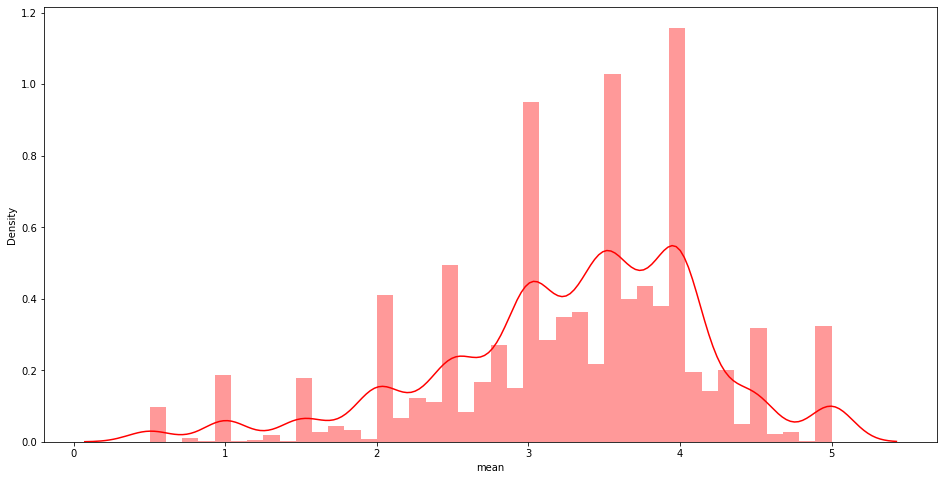

In [ ]:
#이제 시각화 해보자
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
sns.distplot(a=movie_rating_summary['mean'], kde=True, color='r')

#우측에 치우쳐 있는거로 봐서 사람들이 대체적으로 영화에 후한 평점을 준다고 유추 가능

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


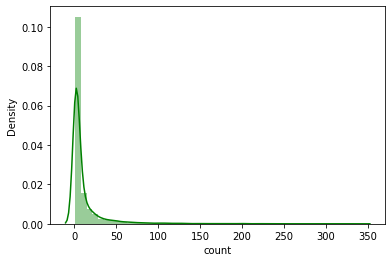

In [ ]:
sns.distplot(a=movie_rating_summary['count'],color ='g')

#영화별로 평점이 몇번 주어졌는지 확인해 볼건데 보통 한번씩 평점을 받은 경우가 많음(좌측에 치우침)

In [ ]:
#10만개의 평점과 9천개의 영화가 주어졌었는데 여기서 몇명의 사용자들이 있는지 확인해 본다 unique

movie_ratings["userId"].nunique()
#671명의 유저가 평점을 줌

671

In [ ]:
#유저별 평점
user_rating_summary = movie_ratings[["userId","rating"]].groupby(["userId"]).agg(["count","median","mean"])

In [ ]:
user_rating_summary.head()
#사용자 1은 박하고 사용자 4는 후함

rating                 
        count median      mean
userId                        
1          20    2.5  2.550000
2          76    3.0  3.486842
3          51    3.5  3.568627
4         204    5.0  4.348039
5         100    4.0  3.910000

In [ ]:
#멀티인덱스 컬럼을 다시 바꿔줌
user_rating_summary.columns =["count","median","mean"]

In [ ]:
user_rating_summary.sort_values("count", ascending=False).head(10)

,count,median,mean
userId,,,
547,2391,3.5,3.366792
564,1868,4.0,3.552463
624,1735,3.0,2.894236
15,1700,3.0,2.621765
73,1610,3.5,3.374224
452,1340,3.0,3.189179
468,1291,3.0,2.965918
380,1063,3.5,3.366416
311,1019,3.0,3.006379


In [ ]:
user_rating_summary.sort_values("median", ascending=False).head(10) #중간값 기준 후하게 준 사람들 (false)

,count,median,mean
userId,,,
230,94,5.0,4.473404
432,62,5.0,4.411290
622,31,5.0,4.725806
499,33,5.0,4.272727
145,38,5.0,4.500000
559,129,5.0,4.418605
473,76,5.0,4.315789
28,50,5.0,4.280000
556,25,5.0,4.400000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


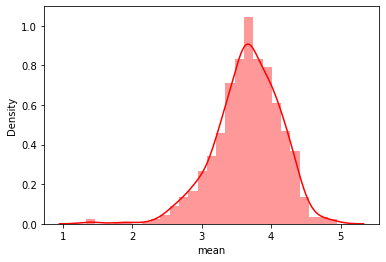

In [ ]:
#시각화 (평점의 평균값이 얼만큼) -> 아까 영화랑 비슷
sns.distplot(a=user_rating_summary['mean'], kde=True, color='r')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


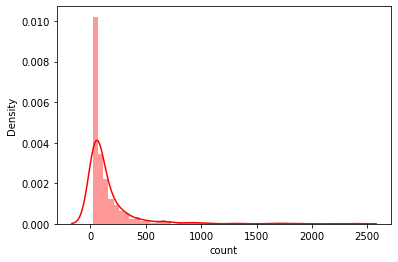

In [ ]:
sns.distplot(a=user_rating_summary['count'], kde=True, color='r')

In [ ]:
def getMovieName(movie_ratings,movieID):
    return movie_ratings[movie_ratings["movieId"]== movieID ][["title","genres"]].values[0]

def getMovieID(movie_ratings,movieName):
    return movie_ratings[movie_ratings["title"]== movieName ][["movieId","genres"]].values[0]
#아이디와 이름 기준으로 위치를 돌려줌

영화 데이터를 surprise 모듈을 통해 로딩

In [ ]:
#리눅스 유틸리티 !wget를 사용해 로컬로 다운로드 받음

!wget "http://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv"

--2022-09-10 17:46:15--  http://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv
Resolving grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)... 3.5.140.106
Connecting to grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)|3.5.140.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2438266 (2.3M) [text/csv]
Saving to: ‘ratings.csv.2’

ratings.csv.2       100%[===================>]   2.33M  1.74MB/s    in 1.3s    

2022-09-10 17:46:17 (1.74 MB/s) - ‘ratings.csv.2’ saved [2438266/2438266]



In [ ]:
#협업 필터링에 쓰는거라 user, item..이렇게 네개로 구성되어 있고 콤마로 구분되어 있으며 첫번쨰 라인은 헤더니까 무시해라

reader = Reader(line_format = 'user item rating timestamp', sep =',', skip_lines=1)

data =Dataset.load_from_file("ratings.csv", reader=reader)

In [ ]:
from surprise import KNNBasic
import heapq #주어진 사용자와 가장 비슷한 사용자 k개를 비교하며 뽑을때 사용
from collections import defaultdict #파이썬 dict의 문제점을 해결해줌
#여기선 이거 안씀 사실 from operator import itemgetter 

In [ ]:
trainSet = data.build_full_trainset()
#지금 로딩된거(데이터)를 test로 나누지 말고 모두 trainset으로 써라 

In [ ]:
# 유사도를 어떻게 측정할거인지 , 코사인, 유저기반 true (사용자기반), +false면 아이템 기반

sim_options ={
    'name':'cosine',
    'user_based': True
}

#knn을 써서 비슷한 사용자들을 클러스팅
model = KNNBasic(sim_options = sim_options)
#trianset을 fit을 줘서 모델에 로딩
model.fit(trainSet)
#compute similarities로 유사도를 얻어 matrix에 그 값(사용자들끼리 비교된 유사도)이 들어감
simsMatrix = model.compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
testUser = '85'
k= 10

#사용자 85번을 기준으로 이 사용자와 비슷한 평점 패턴을 보이는 10명을 찾아서
# 이 열명이 본 작품중 85번이 보지 않은걸 추천할것임

testUserInnerID =trainSet.to_inner_uid(testUser)
#85번의 surprise 내부 아이디는
print(testUserInnerID)
#84번임
similarityRow = simsMatrix[testUserInnerID]
#이 사용자에 해당하는 레코드를 읽어옴

84


In [ ]:
#이 행에 있는 레코드를 내림차순으로 정렬해야 하는데 그냥 정렬하면 일련번호를 잃어버리니까 
#enumerate해줌

users= []
for innerID, score in enumerate(similarityRow):
    if(innerID != testUserInnerID): #자기 자신이랑 비교하는건 아니니까 뻄
        users.append((innerID, score))

In [ ]:
#users 안에는 innerID와 score 두개가 들어가 있는데 인덱스 1인 스코어를 기준으로 가장 큰값 k개를 찾는다

kNeighbors = heapq.nlargest(k, users, key = lambda t : t[1])

In [ ]:
kNeighbors
#사용자 아이디, 유사도(1 = 100프로 똑같)

[(10, 1.0),
 (11, 1.0),
 (13, 1.0),
 (24, 1.0),
 (36, 1.0),
 (44, 1.0),
 (45, 1.0),
 (51, 1.0),
 (53, 1.0),
 (61, 1.0)]

In [ ]:
# 84번과 위의 사용자들의 유사도를 가중치로 준 평점을 누적한다

candidates = defaultdict(float)

for similarUser in kNeighbors:

    innerID= similarUser[0]
    userSimilarityScore = similarUser[1]

    theirRatings =trainSet.ur[innerID]

    for rating in theirRatings:
        candidates[rating[0]] += (rating[1]) * userSimilarityScore

In [ ]:
#사용자가 이미 평가한 아이템들을 제거할 사전을 만든다
#watched에 1로 저장해 두고 아래서 봤던거 있는지 판단할떄 사용
watched =  { }

for itemID,rating in trainSet.ur[testUserInnerID]:
    watched[itemID] = 1


In [ ]:
#합산된 값(평점)을 기준으로 내림차순으로 소팅후 아직 못본 아이템일 경우 추천한다

pos = 0

for itemID, ratingSum in sorted(candidates.items() ,key = lambda k:k[1], reverse = True):
    if not itemID in watched:
        movieID= trainSet.to_raw_iid(itemID)
       # print(movieID, getMovieName(movie_ratings,int(movieID)), ratingSum)
        pos += 1
        if (pos > 10):
            break

In [ ]:
from traitlets.traitlets import default
# 앞의 과정을 한번에 함수로 만들기

def recommendForUser(userID):
    testUserInnerID = trainSet.to_inner_uid(userID)
    similarityRow = simsMatrix[testUserInnerID]

    users =[]
    for innerID, score in enumerate(similarityRow):
        if (innerID != testUserInnerID):
            users.append( (innerID, score))
    
    kNeighbors = heapq.nlargest(k, users, key = lambda t :t[1])

    candidates = defaultdict(float)
    for similarUser in kNeighbors:
        innerID = similarUser[0]
        userSimilarityScore = similarUser[1]
        theirRatings = trainSet.ur[innerID]
        for rating in theirRatings:
            candidates[rating[0]] += (rating[1]) * userSimilarityScore

    watched = { }
    for itemID, rating in trainSet.ur[testUserInnerID]:
        watched[itemID] = 1
    
    pos = 0
    for itemID, ratingSum in sorted(candidates.items(), key = lambda k : k[1], reverse =True ):
        if not itemID in watched :
            movieID = trainSet.to_raw_iid(itemID)
            print(movieID, getMovieName(movie_ratings,  int(movieID)),ratingSum)
            pos += 1
            if (pos>10):
                break

In [ ]:
recommendForUser('85')

79132 ['Inception (2010)' 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX'] 16.5
1196 ['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi'] 12.0
26614 ['Bourne Identity, The (1988)' 'Action|Adventure|Drama|Mystery|Thriller'] 10.0
3996 ['Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'
 'Action|Drama|Romance'] 10.0
58559 ['Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX'] 10.0
1201 ['Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'
 'Action|Adventure|Western'] 9.5
48516 ['Departed, The (2006)' 'Crime|Drama|Thriller'] 9.5
91529 ['Dark Knight Rises, The (2012)' 'Action|Adventure|Crime|IMAX'] 9.5
1270 ['Back to the Future (1985)' 'Adventure|Comedy|Sci-Fi'] 9.5
104841 ['Gravity (2013)' 'Action|Sci-Fi|IMAX'] 9.0
2959 ['Fight Club (1999)' 'Action|Crime|Drama|Thriller'] 9.0


In [186]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [187]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/user_based_collaborative_filtering.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/user_based_collaborative_filtering.ipynb to html
[NbConvertApp] Writing 426807 bytes to /content/drive/MyDrive/Colab Notebooks/user_based_collaborative_filtering.html
